### Load Data

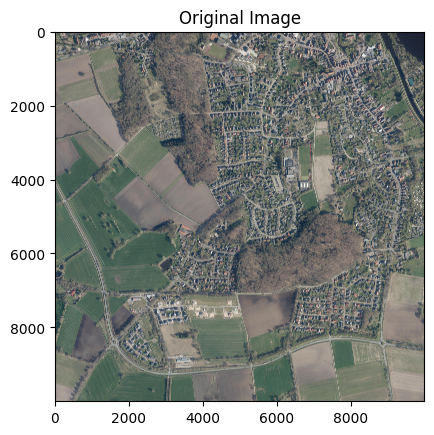

In [3]:
import rasterio
import matplotlib.pyplot as plt

# Load the TIFF file
tif_path = "path to tif file"
with rasterio.open(tif_path) as src:
    image = src.read([1, 2, 3])  # Load first three bands for RGB visualization (if available)

# Plot the image
plt.imshow(image.transpose(1, 2, 0))  # Rasterio loads as (band, height, width)
plt.title("Original Image")
plt.show()


### import labeled data

In [4]:
import labelme

In [9]:
!labelme /Users/wukaiti/Ardhi/image_001.tif


2024-12-29 23:58:56,797 [INFO   ] __init__:get_config:67- Loading config file from: /Users/wukaiti/.labelmerc


In [ ]:
!labelme_json_to_dataset /Users/wukaiti/Ardhi/image_001_labled.json


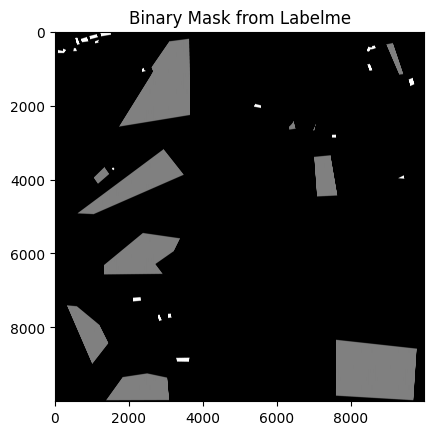

In [75]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load the binary mask
binary_mask = np.array(Image.open("label.png"))

# Visualize the mask
plt.imshow(binary_mask, cmap='gray')
plt.title("Binary Mask from Labelme")
plt.show()


### Verify Binary Masks and Inputs

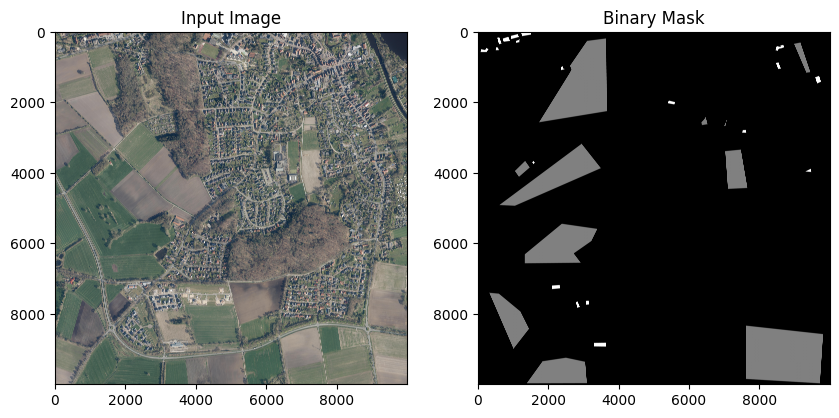

In [95]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load the input image and binary mask
input_image = np.array(Image.open("/image_001.tif"))
binary_mask = np.array(Image.open("/image_001_labled_json/label.png"))

# Verify alignment
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title("Binary Mask")
plt.show()


In [77]:
# Normalize the input image
input_image = input_image / 255.0  # Scale pixel values to [0, 1]


### Image preprocessing & masking

In [96]:
from PIL import Image
import torch
from torchvision import transforms

# Define preprocessing transforms for the input image
image_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Define preprocessing transforms for the binary mask
mask_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch tensor
])

# Load the input image and binary mask using Pillow
image_path = "image_001.tif"  # Replace with your input image path
mask_path = "image_001_labled_json/label.png"   # Replace with your binary mask path

# Open the image and mask
image = Image.open(image_path).convert("RGB")  # Convert to RGB if not already
mask = Image.open(mask_path).convert("L")     # Convert to grayscale for binary mask

# Apply preprocessing
image = image_transform(image)  # Shape: [C, H, W] for PyTorch
mask = mask_transform(mask)     # Shape: [C, H, W] for PyTorch

# Print shapes for verification
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")


Image shape: torch.Size([3, 10000, 10000])
Mask shape: torch.Size([1, 10000, 10000])


### Facilitate patch-based training and enhancing model learning

In [97]:
def create_patches(image, mask, patch_size=256, stride=256):
    """
    Generate smaller patches from the resized image and mask.
    Args:
        image: Tensor of shape [C, H, W].
        mask: Tensor of shape [1, H, W].
        patch_size: Size of each patch.
        stride: Step size for the sliding window.
    Returns:
        image_patches: Tensor of image patches.
        mask_patches: Tensor of mask patches.
    """
    _, h, w = image.shape
    image_patches = []
    mask_patches = []

    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            img_patch = image[:, i:i+patch_size, j:j+patch_size]
            mask_patch = mask[:, i:i+patch_size, j:j+patch_size]
            image_patches.append(img_patch)
            mask_patches.append(mask_patch)

    return torch.stack(image_patches), torch.stack(mask_patches)

# Generate patches
patch_size = 256
stride = 256
image_patches, mask_patches = create_patches(image, mask, patch_size, stride)

print(f"Generated {len(image_patches)} image patches")
print(f"Generated {len(mask_patches)} mask patches")


Generated 1521 image patches
Generated 1521 mask patches


### Visualize the resized and patched images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


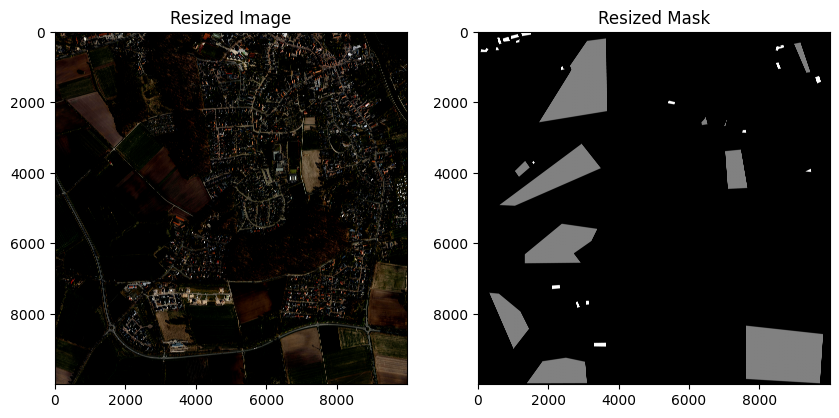

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7882353..1.0].


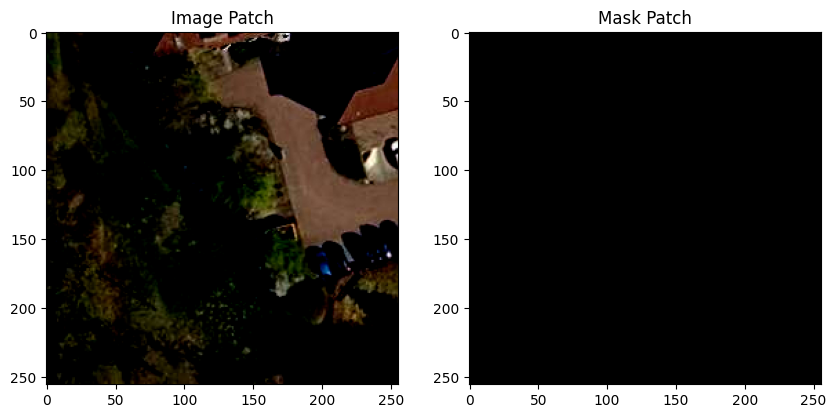

In [98]:
import matplotlib.pyplot as plt

# Visualize resized image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0).numpy())  # [C, H, W] -> [H, W, C]
plt.title("Resized Image")
plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(0).numpy(), cmap="gray")  # Remove channel dimension
plt.title("Resized Mask")
plt.show()

# Visualize a patch
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_patches[0].permute(1, 2, 0).numpy())  # [C, H, W] -> [H, W, C]
plt.title("Image Patch")
plt.subplot(1, 2, 2)
plt.imshow(mask_patches[0].squeeze(0).numpy(), cmap="gray")  # Remove channel dimension
plt.title("Mask Patch")
plt.show()


### Dealing with empty patches

In [ ]:
#loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0]).to(device))
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0]).to(device))


In [100]:
# use patches filtering out no foreground pixels
def create_patches_with_filter(image, mask, patch_size=256, stride=256):
    _, h, w = image.shape
    image_patches, mask_patches = [], []

    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            img_patch = image[:, i:i+patch_size, j:j+patch_size]
            mask_patch = mask[:, i:i+patch_size, j:j+patch_size]

            # Only keep patches with non-zero foreground pixels
            if mask_patch.sum() > 0:
                image_patches.append(img_patch)
                mask_patches.append(mask_patch)

    return torch.stack(image_patches), torch.stack(mask_patches)

image_patches, mask_patches = create_patches_with_filter(image, mask, patch_size=256, stride=256)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..1.0].


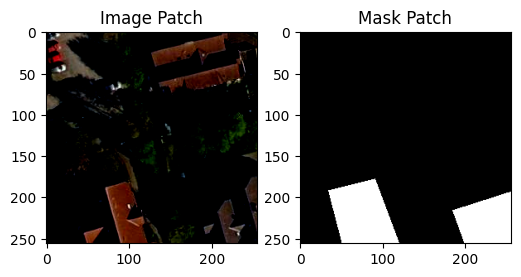

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..1.0].


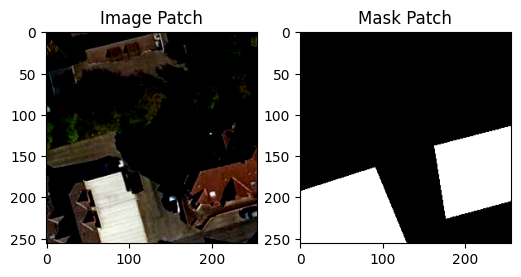

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..1.0].


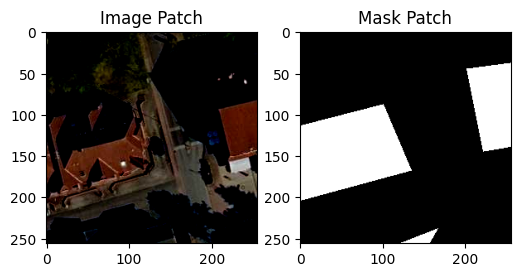

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85882354..1.0].


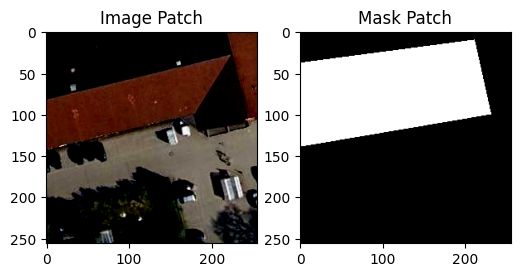

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.827451..0.5921569].


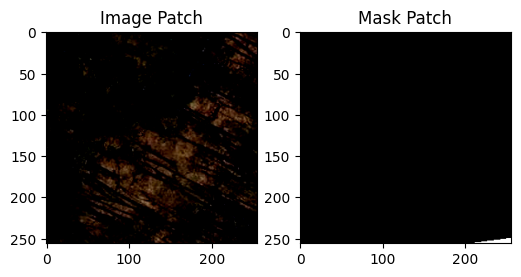

In [101]:
# visualize patches
for i in range(5):  # Show 5 patches
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(image_patches[i].permute(1, 2, 0).cpu().numpy())
    plt.title("Image Patch")
    plt.subplot(1, 2, 2)
    plt.imshow(mask_patches[i].squeeze().cpu().numpy(), cmap="gray")
    plt.title("Mask Patch")
    plt.show()



### Splitting dataset into training, validation, and test sets

In [102]:
from sklearn.model_selection import train_test_split

# Split image and mask patches into training (80%) and validation (20%)
train_images, val_images, train_masks, val_masks = train_test_split(
    image_patches, mask_patches, test_size=0.2, random_state=42
)

# Further split validation set into validation (50%) and test (50%)
val_images, test_images, val_masks, test_masks = train_test_split(
    val_images, val_masks, test_size=0.5, random_state=42
)

print(f"Training set: {len(train_images)} patches")
print(f"Validation set: {len(val_images)} patches")
print(f"Test set: {len(test_images)} patches")


Training set: 252 patches
Validation set: 32 patches
Test set: 32 patches


## Define a Model - Pytorch

### Organize data into pytorch format

In [103]:
from torch.utils.data import Dataset, DataLoader

class PatchDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.masks[idx]

# Create datasets
train_dataset = PatchDataset(train_images, train_masks)
val_dataset = PatchDataset(val_images, val_masks)
test_dataset = PatchDataset(test_images, test_masks)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [104]:
import segmentation_models_pytorch as smp

# Define a UNet model
model = smp.Unet(
    encoder_name="resnet50",        # Pre-trained ResNet34 backbone
    encoder_weights="imagenet",    # Use ImageNet-pretrained weights
    in_channels=3,                 # Input channels (RGB)
    classes=1                      # Output channels (binary mask)
)


### Set up the loss function, optimizer, and an evaluation metric (IoU) for training and evaluating UNet model for binary segmentation

In [105]:
import torch
import torch.nn as nn

# Define loss function
loss_fn = nn.BCEWithLogitsLoss()  # Combines sigmoid and binary cross-entropy

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def iou_score(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = (pred + target).sum(dim=(1, 2, 3)) - intersection

    # Skip empty predictions and masks
    valid = union > 0  # Only consider cases where the union is non-zero
    if valid.sum() == 0:  # If no valid samples, return IoU as 0
        return 0.0

    iou = intersection[valid] / (union[valid] + 1e-6)
    return iou.mean().item()



### Model training

In [106]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10  # Define number of epochs

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        train_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.4f}")


Epoch 1/10, Train Loss: 0.4038
Epoch 2/10, Train Loss: 0.2789
Epoch 3/10, Train Loss: 0.2793
Epoch 4/10, Train Loss: 0.2783
Epoch 5/10, Train Loss: 0.2772
Epoch 6/10, Train Loss: 0.2764
Epoch 7/10, Train Loss: 0.2752
Epoch 8/10, Train Loss: 0.2753
Epoch 9/10, Train Loss: 0.2741
Epoch 10/10, Train Loss: 0.2729


In [107]:
model.eval()
val_loss = 0
val_iou = 0

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        val_loss += loss.item()

        # Compute IoU
        val_iou += iou_score(outputs, masks)

print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation IoU: {val_iou / len(val_loader):.4f}")


Validation Loss: 0.3044, Validation IoU: 0.0000


In [108]:
model.eval()
test_iou = 0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        test_iou += iou_score(outputs, masks)

print(f"Test IoU: {test_iou / len(test_loader):.4f}")


Test IoU: 0.0000


In [109]:
torch.save(model.state_dict(), "building_segmentation_model.pth")


In [110]:
model.load_state_dict(torch.load("building_segmentation_model.pth"))
model.eval()


/var/folders/_3/95ys3_5j3m338xqx08t_py280000gn/T/ipykernel_2362/2152506071.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("building_seg

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

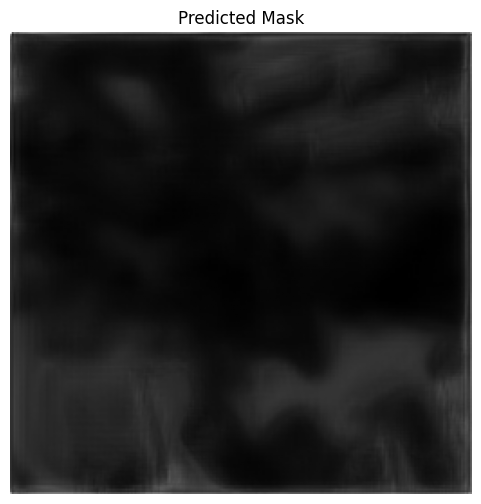

In [111]:
# Predict on a new image
model.eval()  # Set the model to evaluation mode

# Select a test image patch and move it to the correct device
test_image = image_patches[0].unsqueeze(0).to(device)  # Add batch dimension and move to GPU/CPU

with torch.no_grad():  # Disable gradient calculation for inference
    # Forward pass to generate prediction
    predicted_mask = model(test_image)
    
    # Apply sigmoid to scale predictions to [0, 1]
    predicted_mask = torch.sigmoid(predicted_mask)
    
    # Squeeze to remove batch and channel dimensions (convert [1, 1, H, W] to [H, W])
    predicted_mask = predicted_mask.squeeze().cpu().numpy()

# Visualize the predicted mask
plt.figure(figsize=(6, 6))
plt.imshow(predicted_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")  # Remove axes for better visualization
plt.show()
